# Zadanie 1

poznamka: ziadna cast kodu nebola v tomto notebooku spustena. Tento dokument bol vytvoreny z viacerych notebookov, ktore su ulozene na mojom gite

In [1]:
%matplotlib inline
from psycopg2.extras import RealDictCursor
import psycopg2
import nltk
import pandas as pd
import re
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
import matplotlib.pyplot as plt

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Marek\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Pouzite funkcie

create_function() - vytvorenie pripojenia do databazy
remove_emoji(tweet) - vymazanie emoji z tweetu
remove_mentions_and_hashtags(tweet) - vymazanie mentions a hashtagov z tweetu
clarify_tweet(tweet) - funkcia vycisti tweet volanim predoslych funkcii a vrati sentiment


In [2]:
def create_connection():
    return psycopg2.connect("dbname=twitter user=postgres password=postgres host=localhost port=5433")

def remove_emoji(tweet):
    emoji = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002500-\U00002BEF"
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"
        u"\u3030"
        "]+", re.UNICODE)
    return re.sub(emoji, '', tweet)
    
def remove_mentions_and_hashtags(tweet):
    clarified_tweet = re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9_]+)", " ", tweet)
    return ' '.join(clarified_tweet.split())

def clarify_tweet(tweet):
    no_emoji = remove_emoji(tweet)
    text = remove_mentions_and_hashtags(no_emoji)
    return sid.polarity_scores(text)

## Uloha 2

Vytvorenie potrebnych stlpcov (neg, neu, pos, compound):

In [ ]:
add_columns_query = """
ALTER TABLE tweets
ADD COLUMN neg DECIMAL DEFAULT 0,
ADD COLUMN neu DECIMAL DEFAULT 0,
ADD COLUMN pos DECIMAL DEFAULT 0,
ADD COLUMN compound DECIMAL DEFAULT 0
"""

try:
    conn = create_connection();
    cur = conn.cursor()
    cur.execute(add_columns_query)
    conn.commit()
    conn.close()
except:
    conn.rollback()

Select potrebnych udajov pre ulohu c. 2.

In [ ]:
select_query = """
SELECT DISTINCT t.id, t.content, t.neg, t.neu, t.pos, t.compound
FROM tweets t
JOIN tweet_hashtags th ON th.tweet_id = t.id
JOIN hashtags h ON h.id = th.hashtag_id
WHERE h.value ILIKE any (array[
    '%DeepstateVirus%',
    '%DeepStateFauci%',
    '%DeepStateVaccine%',
    '%QAnon%',
    '%Agenda21%',
    '%CCPVirus%',
    '%ClimateChangeHoax%',
    '%GlobalWarmingHoax%',
    '%ChinaLiedPeopleDied%',
    '%SorosVirus%',
    '%5GCoronavirus%',
    '%MAGA%',
    '%WWG1WGA%',
    '%Chemtrails%',
    '%flatEarth%',
    '%MoonLandingHoax%',
    '%moonhoax%',
    '%illuminati%',
    '%pizzaGateIsReal%',
    '%PedoGateIsReal%',
    '%911truth%',
    '%911insidejob%',
    '%reptilians%'
])
"""

conn = create_connection()
df = pd.read_sql_query(select_query, con=conn)
conn.close()

Vycistenie tweetov od emoji, mentions, hashtagov a nasledne vypocet sentimentu:

In [ ]:
try:
    sid = SentimentIntensityAnalyzer()
    df['vader'] = df['content'].apply(lambda x : clarify_tweet(x))
    df['neg'] = df['vader'].apply(lambda x : x['neg'])
    df['neu'] = df['vader'].apply(lambda x : x['neu'])
    df['pos'] = df['vader'].apply(lambda x : x['pos'])
    df['compound'] = df['vader'].apply(lambda x : x['compound'])
    
except e:
    print(e)

Update jednotlivych hodnot selectnutych tweetov v databaze:

In [ ]:
try:
    conn = create_connection()
    cur = conn.cursor()

    for index, row in df.iterrows():
        update_query = """
        UPDATE tweets
        SET neg = {},
            neu = {},
            pos = {},
            compound = {}
        WHERE '{}' = tweets.id;
        """.format(row['neg'], row['neu'], row['pos'], row['compound'], row['id'])
        cur.execute(update_query)

    conn.commit()
    conn.close()
    
except:
    pass

In [3]:
select_uloha2 = """
SELECT t.id, t.neg, t.neu, t.pos, t.compound
FROM tweets t
LIMIT 5;
"""

conn = create_connection()
df = pd.read_sql_query(select_uloha2, con=conn)
conn.close()
df

,id,neg,neu,pos,compound
0,1220798255098777601,0.0,0.0,0.0,0.0
1,1220790544009519104,0.0,0.0,0.0,0.0
2,1220798255992201217,0.0,0.0,0.0,0.0
3,1220798256608878598,0.0,0.0,0.0,0.0
4,1220798259431645185,0.0,0.0,0.0,0.0


## Uloha 3

Vytvorenie potrebnych tabuliek:

In [ ]:
create_table_theories = """
CREATE TABLE theories (
    id SERIAL PRIMARY KEY,
    theory VARCHAR(50)
);
"""

create_table_tweets_theories = """
CREATE TABLE tweets_theories (
    id SERIAL PRIMARY KEY,
    tweet_id VARCHAR(20) NOT NULL,
    theory_id INTEGER NOT NULL,
    FOREIGN KEY (tweet_id) REFERENCES tweets(id) ON UPDATE CASCADE ON DELETE RESTRICT,
    FOREIGN KEY (theory_id) REFERENCES theories(id) ON UPDATE CASCADE ON DELETE RESTRICT
);
"""

conn = create_connection();
cur = conn.cursor()
cur.execute(create_table_theories)
cur.execute(create_table_tweets_theories)
conn.commit()
conn.close()

Naplnenie tabulky 'theories':

In [ ]:
fill_theories = """
INSERT INTO theories(theory)
VALUES  ('Deep State'),
        ('Qanon'),
        ('New world order'),
        ('The virus escaped from a Chinese lab'),
        ('Global Warming is HOAX'),
        ('COVID19 and microchipping'),
        ('COVID19 is spreaded by 5G'),
        ('Moon landing is fake'),
        ('9/11 was inside job'),
        ('Pizzagate conspiracy theory'),
        ('Chemtrails'),
        ('FlatEarth'),
        ('Illuminati'),
        ('Reptilian conspiracy theory');
"""

conn = create_connection()
cur = conn.cursor()
cur.execute(fill_theories)
conn.commit()
conn.close()

Naplnenie tabulky 'tweets_theories', ktora sluzi na mapovanie jednotlivych tweetov na teorie:

In [ ]:
fill_tweets_theories = """
INSERT INTO tweets_theories (tweet_id, theory_id)
SELECT DISTINCT t.id, CASE
    WHEN h.value ILIKE any (array['%deepstatevirus%', '%deepstatefauci%', '%deepstatevaccine%'])
    THEN (SELECT id FROM theories WHERE theory ILIKE 'Deep State')
    WHEN h.value ILIKE any (array['%QAnon%', '%MAGA%', '%WWG1WGA%'])
    THEN (SELECT id FROM theories WHERE theory ILIKE 'Qanon')
    WHEN h.value ILIKE '%Agenda21%'
    THEN (SELECT id FROM theories WHERE theory ILIKE 'New world%')
    WHEN h.value ILIKE any (array['%CCPVirus%', '%ChinaLiedPeopleDied%'])
    THEN (SELECT id FROM theories WHERE theory ILIKE 'The virus escaped%')
    WHEN h.value ILIKE any (array['%ClimateChangeHoax%', '%GlobalWarmingHoax%'])
    THEN (SELECT id FROM theories WHERE theory ILIKE 'Global warming%')
    WHEN h.value ILIKE '%SorosVirus%'
    THEN (SELECT id FROM theories WHERE theory ILIKE 'COVID19 and %')
    WHEN h.value ILIKE '%5GCoronavirus%'
    THEN (SELECT id FROM theories WHERE theory ILIKE 'COVID19 is s%')
    WHEN h.value ILIKE any (array['%MoonLandingHoax%', '%moonhoax%'])
    THEN (SELECT id FROM theories WHERE theory ILIKE 'Moon landing%')
    WHEN h.value ILIKE any (array['%911truth%', '%911insidejob%'])
    THEN (SELECT id FROM theories WHERE theory ILIKE '9/11%')
    WHEN h.value ILIKE any (array['%pizzaGateIsReal%', '%PedoGateIsReal%'])
    THEN (SELECT id FROM theories WHERE theory ILIKE 'Pizzagate%')
    WHEN h.value ILIKE '%Chemtrails%'
    THEN (SELECT id FROM theories WHERE theory ILIKE 'Chemtrails')
    WHEN h.value ILIKE '%FlatEarth%'
    THEN (SELECT id FROM theories WHERE theory ILIKE 'FlatEarth')
    WHEN h.value ILIKE '%illuminati%'
    THEN (SELECT id FROM theories WHERE theory ILIKE 'illuminati')
    WHEN h.value ILIKE '%reptilians%'
    THEN (SELECT id FROM theories WHERE theory ILIKE 'reptilian%')
END AS theories_id
FROM tweets t
JOIN tweet_hashtags as th ON t.id = th.tweet_id
JOIN hashtags as h ON h.id = th.hashtag_id
WHERE h.value ILIKE any (array[
    '%DeepstateVirus%',
    '%DeepStateFauci%',
    '%DeepStateVaccine%',
    '%QAnon%',
    '%Agenda21%',
    '%CCPVirus%',
    '%ClimateChangeHoax%',
    '%GlobalWarmingHoax%',
    '%ChinaLiedPeopleDied%',
    '%SorosVirus%',
    '%5GCoronavirus%',
    '%MAGA%',
    '%WWG1WGA%',
    '%Chemtrails%',
    '%flatEarth%',
    '%MoonLandingHoax%',
    '%moonhoax%',
    '%illuminati%',
    '%pizzaGateIsReal%',
    '%PedoGateIsReal%',
    '%911truth%',
    '%911insidejob%',
    '%reptilians%'
])
"""

conn = create_connection()
cur = conn.cursor()
cur.execute(fill_tweets_theories)
conn.commit()
conn.close()

In [6]:
select_uloha3 = """
SELECT t.id, th.theory
FROM tweets t
JOIN tweets_theories tt ON tt.tweet_id = t.id
JOIN theories th ON th.id = tt.theory_id
LIMIT 5;
"""

conn = create_connection()
df = pd.read_sql_query(select_uloha3, con=conn)
conn.close()
df

,id,theory
0,1034289685227614208,Qanon
1,1034289685227614208,Pizzagate conspiracy theory
2,1037494012033343488,Qanon
3,1038674252940148736,Qanon
4,1039279051456831489,Qanon


## Uloha 4

Vytvorenie potrebnej tabulky:

In [ ]:
create_table = """
CREATE TABLE sentiment_ratio_by_weeks (
    id SERIAL PRIMARY KEY,
    theory_id INTEGER NOT NULL,
    tweet_count INTEGER DEFAULT 0,
    tweet_extreme_count INTEGER DEFAULT 0,
    tweet_neutral_count INTEGER DEFAULT 0,
    ratio DECIMAL DEFAULT 0,
    week INTEGER,
    year INTEGER,
    FOREIGN KEY (theory_id) REFERENCES theories(id) ON UPDATE CASCADE ON DELETE RESTRICT
)
"""

conn = create_connection();
cur = conn.cursor()
cur.execute(create_table)
conn.commit()
conn.close()

Naplnenie vytvorenej tabulky:

In [ ]:
select = """
INSERT INTO sentiment_ratio_by_weeks (theory_id, year, week, tweet_extreme_count, tweet_neutral_count, tweet_count, ratio)
SELECT sub.*, CASE WHEN sub.neutral = 0 THEN NULL ELSE sub.extreme::DECIMAL / sub.neutral::DECIMAL END
FROM
(SELECT tt.theory_id, DATE_PART('year', t.happened_at) as year, DATE_PART('week', t.happened_at) as week, COUNT(CASE WHEN t.compound < -0.5 OR t.compound > 0.5 THEN t.compound END) as extreme, COUNT(CASE WHEN t.compound >= -0.5 AND t.compound <= 0.5 THEN t.compound END) as neutral, count(tt.theory_id) as t_count
FROM tweets t
JOIN tweets_theories tt ON tt.tweet_id = t.id
GROUP BY tt.theory_id, year, week) as sub
"""

conn = create_connection();
cur = conn.cursor()
cur.execute(select)
conn.commit()
conn.close()

Select dat, potrebnych pre vizualizaciu pomeru extremnych a neutralnych tweetov jednotlivych teorii podla tyzdnov:

In [7]:
data = """
SELECT t.theory, s.tweet_extreme_count, s.tweet_neutral_count, s.week, s.year
FROM sentiment_ratio_by_weeks s
JOIN theories t ON t.id = s.theory_id
ORDER BY t.theory, s.year, s.week ASC;
"""

conn = create_connection()
df = pd.read_sql_query(data, con=conn)
conn.close()

Rozdelenie datasetu na viacero mensich datasetov pre jednotlive teorie a vykreslenie grafov:

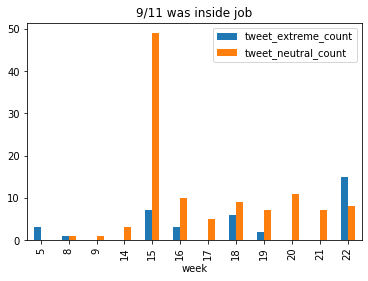

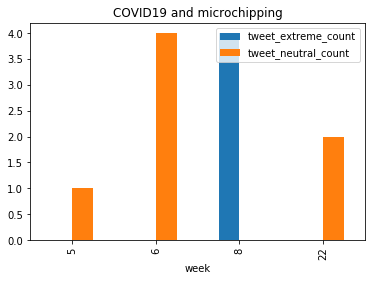

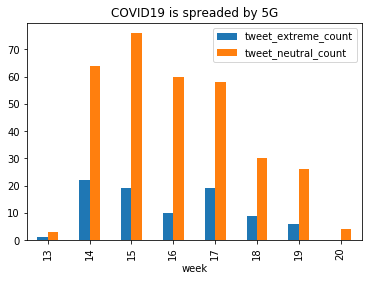

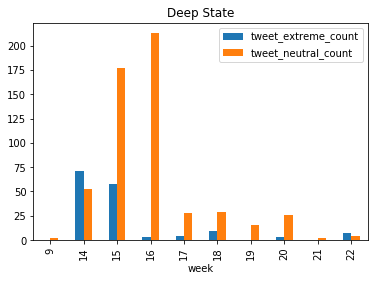

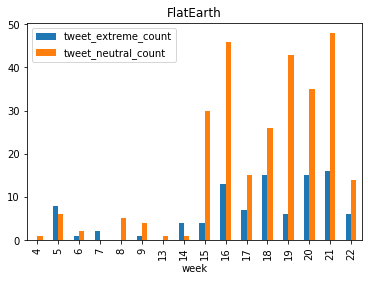

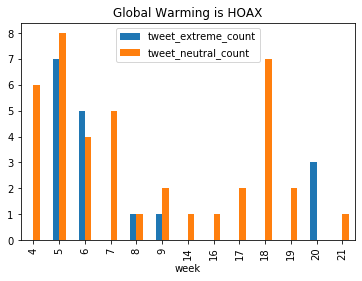

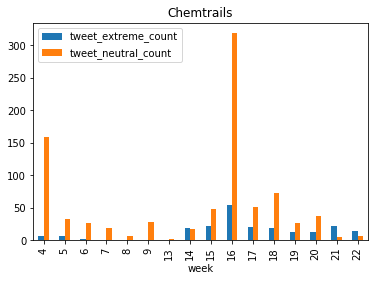

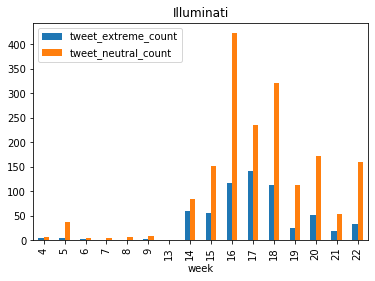

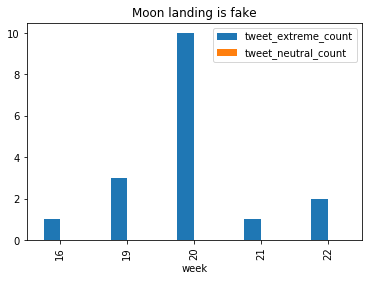

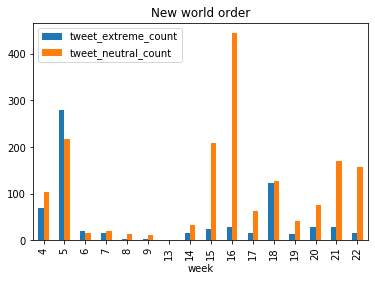

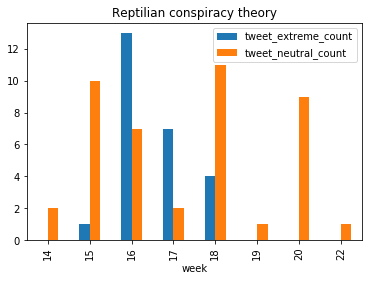

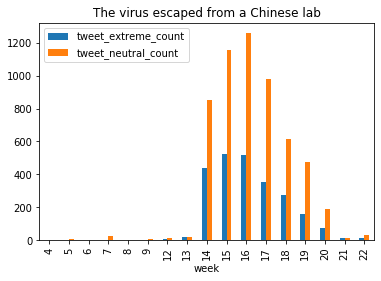

In [8]:
df_theory_1 = df[df['theory'] == '9/11 was inside job']
df_theory_2 = df[df['theory'] == 'COVID19 and microchipping']
df_theory_3 = df[df['theory'] == 'COVID19 is spreaded by 5G']
df_theory_4 = df[df['theory'] == 'Deep State']
df_theory_5 = df[df['theory'] == 'FlatEarth']
df_theory_6 = df[df['theory'] == 'Global Warming is HOAX']
df_theory_7 = df[df['theory'] == 'Chemtrails']
df_theory_8 = df[df['theory'] == 'Illuminati']
df_theory_9 = df[df['theory'] == 'Moon landing is fake']
df_theory_10 = df[df['theory'] == 'New world order']
df_theory_11 = df[df['theory'] == 'Pizzagate conspiracy theory']
df_theory_12 = df[df['theory'] == 'Qanon']
df_theory_13 = df[df['theory'] == 'Reptilian conspiracy theory']
df_theory_14 = df[df['theory'] == 'The virus escaped from a Chinese lab']
df_theory_1.plot.bar(title='9/11 was inside job', x='week', y=['tweet_extreme_count','tweet_neutral_count'])
df_theory_2.plot.bar(title='COVID19 and microchipping', x='week', y=['tweet_extreme_count','tweet_neutral_count'])
df_theory_3.plot.bar(title='COVID19 is spreaded by 5G', x='week', y=['tweet_extreme_count','tweet_neutral_count'])
df_theory_4.plot.bar(title='Deep State', x='week', y=['tweet_extreme_count','tweet_neutral_count'])
df_theory_5.plot.bar(title='FlatEarth', x='week', y=['tweet_extreme_count','tweet_neutral_count'])
df_theory_6.plot.bar(title='Global Warming is HOAX', x='week', y=['tweet_extreme_count','tweet_neutral_count'])
df_theory_7.plot.bar(title='Chemtrails', x='week', y=['tweet_extreme_count','tweet_neutral_count'])
df_theory_8.plot.bar(title='Illuminati', x='week', y=['tweet_extreme_count','tweet_neutral_count'])
df_theory_9.plot.bar(title='Moon landing is fake', x='week', y=['tweet_extreme_count','tweet_neutral_count'])
df_theory_10.plot.bar(title='New world order', x='week', y=['tweet_extreme_count','tweet_neutral_count'])
df_theory_13.plot.bar(title='Reptilian conspiracy theory', x='week', y=['tweet_extreme_count','tweet_neutral_count'])
df_theory_14.plot.bar(title='The virus escaped from a Chinese lab', x='week', y=['tweet_extreme_count','tweet_neutral_count'])

Nakolko teorie 'Pizzagate conspiracy theory' a 'Qanon' obsahuju tweety z viacerych rokov, je potrebne upravit oznacenie tyzdnov (rok-tyzden):

In [9]:
df_theory_11['year_week'] = df_theory_11['year'].astype(str) + '-' + df_theory_11['week'].astype(str)

C:\Users\Marek\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 0, 'year-week')

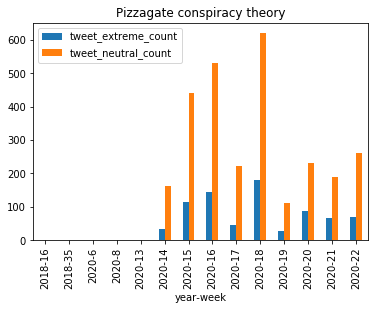

In [10]:
ax1 = df_theory_11.plot.bar(title='Pizzagate conspiracy theory', x='year_week', y=['tweet_extreme_count','tweet_neutral_count'])
ax1.set_xlabel('year-week')

In [11]:
df_theory_12['year_week'] = df_theory_12['year'].astype(str) + '-' + df_theory_12['week'].astype(str)

C:\Users\Marek\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 0, 'year-week')

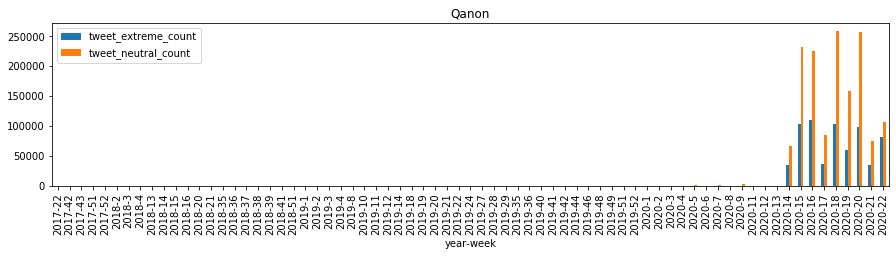

In [12]:
ax2 = df_theory_12.plot.bar(title='Qanon', x='year_week', y=['tweet_extreme_count','tweet_neutral_count'], figsize=(15,3))
ax2.set_xlabel('year-week')

## Uloha 5

Vytvorenie novej tabulky pre ulohu 5 a jej naplnenie:

In [ ]:
create = """
CREATE TABLE top_extreme_accounts (
    id SERIAL PRIMARY KEY,
    author_id BIGINT NOT NULL,
    name CHARACTER VARYING(200),
    screen_name CHARACTER VARYING(200),
    tweet_count INTEGER,
    theory_id INTEGER NOT NULL,
    FOREIGN KEY (author_id) REFERENCES accounts(id) ON UPDATE CASCADE ON DELETE RESTRICT,
    FOREIGN KEY (theory_id) REFERENCES theories(id) ON UPDATE CASCADE ON DELETE RESTRICT
)
"""

insert = """
INSERT INTO top_extreme_accounts (author_id, name, screen_name, theory_id, tweet_count)
SELECT sub.id, sub.name, sub.screen_name, sub.theory_id, sub.count
FROM
(SELECT ac.id, ac.name, ac.screen_name, th.id theory_id, count(t.id), row_number() OVER (Partition BY th.theory ORDER BY count(t.id) DESC) AS rank
FROM tweets t
JOIN tweets_theories tt ON tt.tweet_id = t.id
JOIN theories th ON th.id = tt.theory_id
JOIN accounts ac ON ac.id = t.author_id
WHERE t.compound > 0.5 OR t.compound < -0.5
GROUP BY ac.id, ac.name, ac.screen_name, th.id) as sub
WHERE sub.rank <= 10;
"""

conn = create_connection()
cur = conn.cursor()
cur.execute(create)
cur.execute(insert)
conn.commit()
conn.close()

In [13]:
select_uloha5 = """
SELECT t.author_id, t.name, t.screen_name, th.theory, tweet_count
FROM top_extreme_accounts t
JOIN theories th ON th.id = t.theory_id
LIMIT 5;
"""

conn = create_connection()
df = pd.read_sql_query(select_uloha5, con=conn)
conn.close()
df

,author_id,name,screen_name,theory,tweet_count
0,55905770,Miriam Selmi Reed,mimiselmi,9/11 was inside job,2
1,2549547798,David Hooper,DaveHooper15,9/11 was inside job,2
2,1242848729796935685,QuietBuck2,QuietBuck2,9/11 was inside job,1
3,1243433781597548546,ᏊᎣ𝕶𝖆𝖗𝖔ᎣᏊ,Karolin20775637,9/11 was inside job,1
4,1237444146236919808,Be L❤️VE,SparrowHawkClwd,9/11 was inside job,1


## Uloha 6

Select podla zadania ulohy 6:

In [14]:
select = """
SELECT sub.theory, sub.value, sub.count
FROM
(SELECT th.theory, h.value, h.id, count(h.id), row_number() OVER (Partition by th.theory ORDER BY count(h.id) DESC) as rank
FROM tweets t
JOIN tweets_theories tt ON tt.tweet_id = t.id
JOIN theories th ON th.id = tt.theory_id
JOIN tweet_hashtags ths ON ths.tweet_id = t.id
JOIN hashtags h ON h.id = ths.hashtag_id
WHERE t.compound > 0.5 OR t.compound < -0.5
GROUP BY th.theory, h.value, h.id) as sub
WHERE sub.rank <= 10;
"""

conn = create_connection()
df = pd.read_sql_query(select, con=conn)
conn.close()

In [15]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df)

                                   theory                value   count
0                     9/11 was inside job                QAnon      27
1                     9/11 was inside job             911Truth      24
2                     9/11 was inside job              WWG1WGA      19
3                     9/11 was inside job    TheGreatAwakening      16
4                     9/11 was inside job                 WTC7      16
5                     9/11 was inside job         QAnonGermany      14
6                     9/11 was inside job    WWG1WGA_WORLDWIDE      14
7                     9/11 was inside job             911truth       8
8                     9/11 was inside job                Qanon       5
9                     9/11 was inside job           demolition       4
10              COVID19 and microchipping           SorosVirus       4
11              COVID19 and microchipping          coronavirus       4
12              COVID19 is spreaded by 5G        5GCoronavirus      85
13    